### НИЯУ МИФИ. Лаботаторная работа #3. Полищук Максим, Б20-505

# Используемая система

```
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  6
  On-line CPU(s) list:   0-5
Vendor ID:               GenuineIntel
  Model name:            12th Gen Intel(R) Core(TM) i5-12400F
```

## Оценка сложности
- Лучший случай: O(1)
- Худший случай: O(n^2)

```
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define MROWS 100

void InsertSort(int *arr, int i, int length,  int half){
  int temp = 0;
  int j = 0;

  for (int f = half + i; f < length; f = f + half)
  {
    j = f;
    while(j > i && arr[j-half] > arr[j])
    {
      temp = arr[j];
      arr[j] = arr[j-half];
      arr[j-half] = temp;
      j = j -half;
    }
  }
}

double shellSortParallel(int *array, int length, int cur_threads)
{
  int h;
  int j = 0;
  int temp = 0;
  int i = 0;
  for(h =length/2; h > 0; h = h/2)
  {
    #pragma omp parallel for num_threads(cur_threads) shared(array, length, h, i)  default(none)
    for( i = 0; i < h; i++)
    {
      InsertSort(array, i, length, h);
    }
  }
}


int main(int argc, char** argv)
{
    const int count = 1000000;         ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed

    int** matrix = 0;               ///< The array we need to find the max in
    srand(random_seed);
    double start, end;

    /* Generate the random MATRIX */
    matrix = (int**)calloc(MROWS, sizeof(int*));
    for (int i = 0; i < MROWS; i++) {
        matrix[i] = (int*)calloc(count, sizeof(int));
    }
    for (int i = 0; i < MROWS; i++) {
        for (int elem = 0; elem < count; elem++) {
            matrix[i][elem] = rand();
        }
    }

    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }
    int threads = omp_get_max_threads() * 2;

    for (int thread = 1; thread <= threads; thread++) {
        printf("<--- START FOR %d THREADS --->\n", thread);
        // create matrix for each thread

        for (int row = 0; row < MROWS; row++) {
            int *curr_arr = calloc(count, sizeof(int));
            for (int i = 0; i < count; i++) {
                curr_arr[i] = matrix[row][i];
            }
            start = omp_get_wtime();
            
            shellSortParallel(curr_arr, count, thread);

            end = omp_get_wtime();
            if (row != MROWS - 1) {
                fprintf(fp, "%f;", end-start);
            } else {
                fprintf(fp, "%f\n", end-start);
            }
            // for (int i = 0; i < count; i ++) {
            //     printf("%d | ", curr_arr[i]);
            // }
            free(curr_arr);
        }
    }
    fclose(fp);
    printf("Exit...\n");
    return(0);
}
```

In [1]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

dataset = []
with open("trace.txt", "r") as f:
    for _ in range(12):
        line = list(map(float, f.readline().split(";")))
        dataset.append(line)
        
for i in range(len(dataset)):
    line = dataset[i]
    line.sort()
    line = line[10:-10]
    dataset[i] = line

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
data = []
for i, line in enumerate(dataset):
    data.append([i+1, (sum(line)/len(line))*1000, "Real"])
saved = data.copy()
data1 = data
data_df = pd.DataFrame(data, columns=["Threads", "AvgTime", "Type"])
for i in range(1, len(data1)): 
    data1[i] = [data1[i][0], data1[0][1] / data1[i][0], "Perfect"]
data1[0][2] = "Perfect"
# pdf = pd.DataFrame(data1, columns=["Threads", "AvgTime"])
data1 = pd.DataFrame(data1, columns=["Threads", "AvgTime", "Type"])
all_data = pd.concat([data1, data_df])

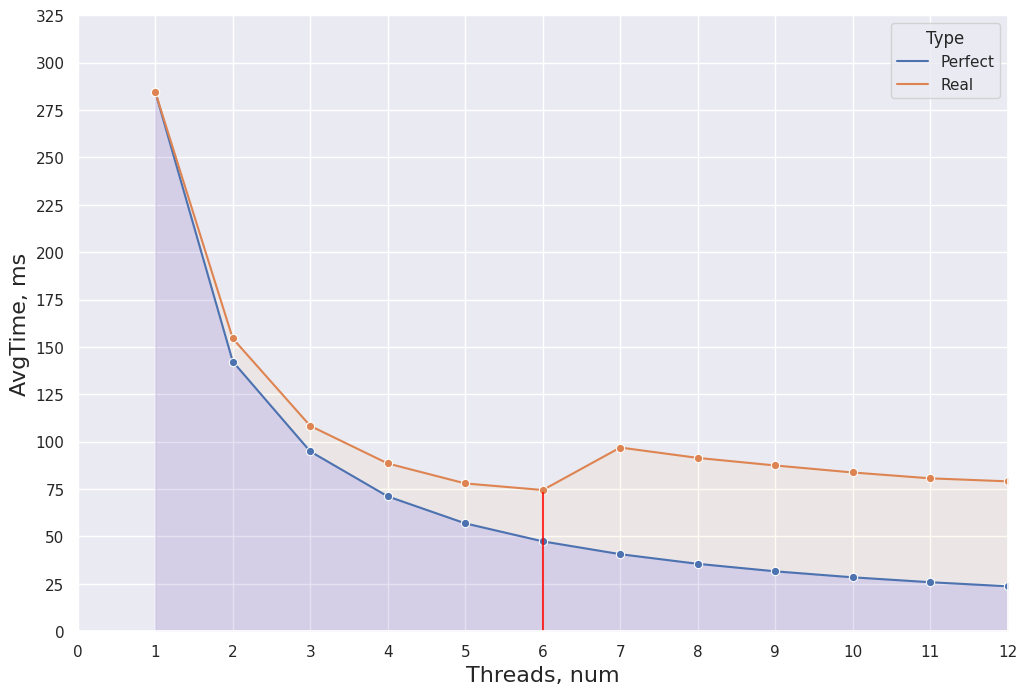

In [19]:
p = sns.lineplot(x="Threads", y="AvgTime", hue="Type", marker="o", data=all_data)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("AvgTime, ms", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

p.fill_between(x1, y1, color="blue", alpha=0.1)
l2 = p.lines[1]

x2 = l2.get_xydata()[:, 0]
y2 = l2.get_xydata()[:, 1]

p.fill_between(x2, y2, color="orange", alpha=0.05)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, 13))
_ = p.set_xticklabels(str(i) for i in range(0, 13))
_ = p.set_yticks(range(0, 350, 25))
_ = p.set_yticklabels([str(i) for i in range(0, 350, 25)])
_ = p.axvline(x=6, ymax=0.225, color="red", alpha=0.8)

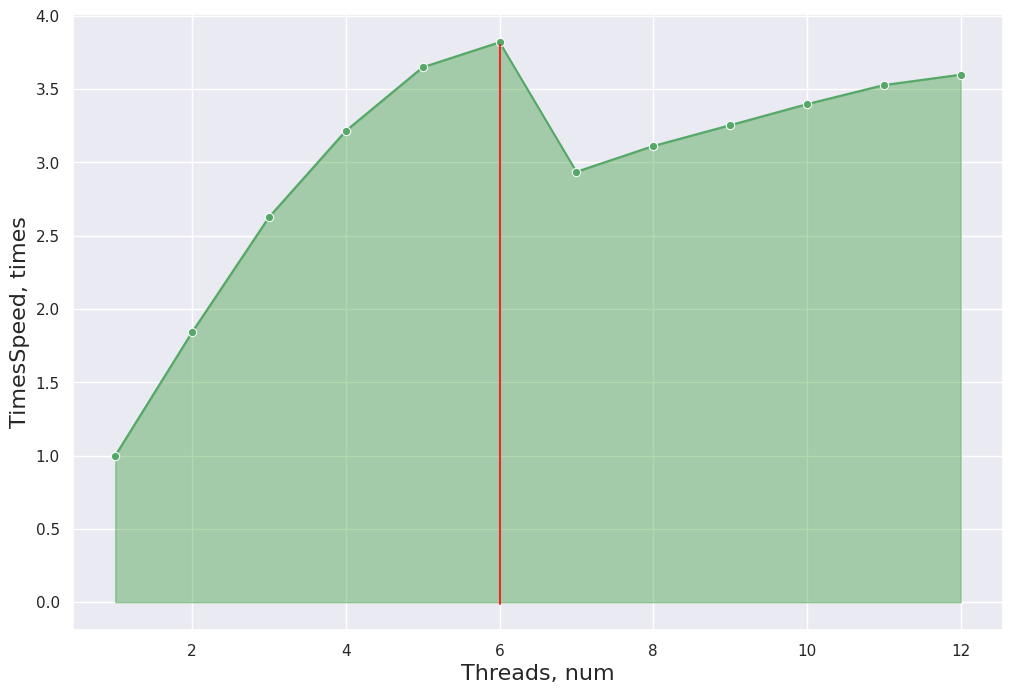

In [24]:
accceleration = [0] * 12
for i in range(0, len(accceleration)):
    accceleration[i] = [saved[i][0], saved[0][1]/saved[i][1]]
a_df = pd.DataFrame(accceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='g')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="green", alpha=0.3)
_ = p.axvline(x=6, ymin=0.043 ,ymax=0.95, color="red", alpha=0.8)

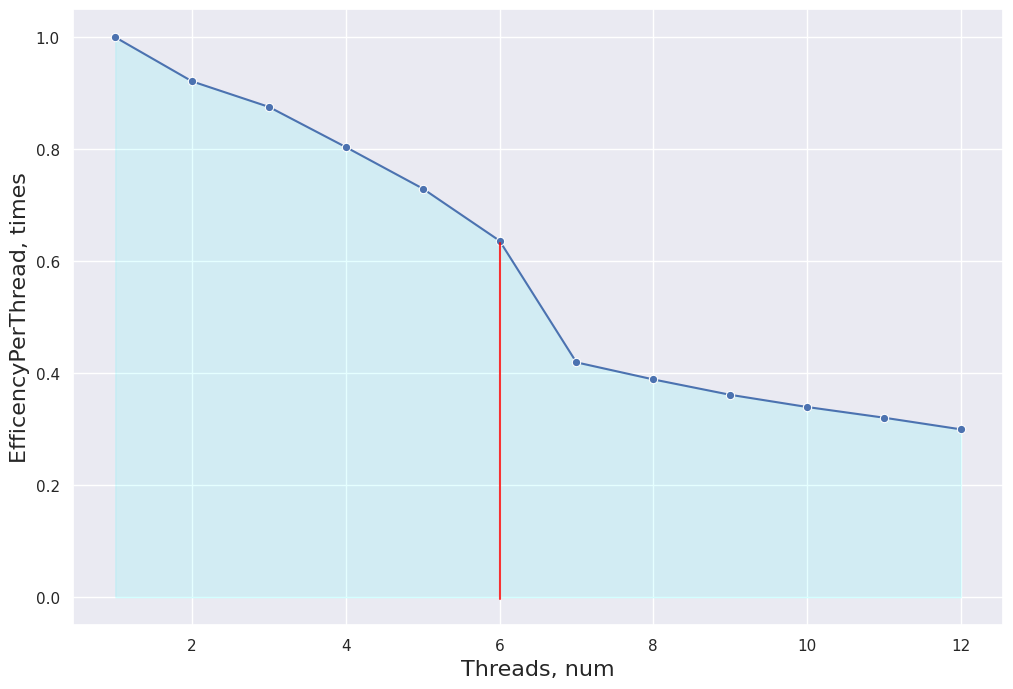

In [26]:
per_thread = [0] * 12
for i in range(0, len(per_thread)):
    per_thread[i] = [accceleration[i][0], accceleration[i][1]/accceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='b')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.axvline(x=6, ymin=0.043 ,ymax=0.62, color="red", alpha=0.8)

## Заключение
- В который раз я выяснил, что использование допольнительных("виртульных") потоков приводит к падению производительности
- Что ипользование параллелелизма в алгоритмах сортировки показывает себя эффективнее чем в работе с массивами (прирост ~3.5 раз по времени исполнения на 6 ядрах)
- В данной работе я ознакомился с созданием параллельных алгоритмов сортировки.